In [53]:
!pip install jupyterlab-latex

  Obtaining dependency information for jupyterlab-latex from https://files.pythonhosted.org/packages/60/10/2281b23c25b3e8680ceafb768302d6361ec6dda668876264583ac1e172d5/jupyterlab_latex-4.3.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 382.5/382.5 kB 5.3 MB/s eta 0:00:00a 0:00:01


# Import

In [51]:
import requests
import pdfplumber
import os
import time
import json
import itertools
import re
import graphviz
from IPython.display import Image, display
import pydot as dot
import networkx as nx
import random
from functools import reduce
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True) # Remove this if latex is not installed and accessible

# Reading and Writing Files

In [2]:
def save(data, filename):
    with open(filename, "w") as f:
        f.write(json.dumps(data))

def load(filename):
    if os.path.exists(filename):
        with open(filename, "r") as f:
            j = f.read()
        return json.loads(j)
    else:
        return {}

# Seed papers

In [3]:
seed_papers = [
         "204e3073870fae3d05bcbc2f6a8e263d9b72e776", # attention is all you need
         "5bbb6f9a8204eb13070b6f033e61c84ef8ee68dd", # Deep Reinforcement Learning from Human Preferences
         "7a15950dc71079285a4eaf195de5aadd87c41b40", #Fine-Tuning Language Models from Human Preferences
         "d766bffc357127e0dc86dd69561d5aeb520d6f4c", #Training language models to follow instructions with human feedback
         "c6f913e4baa7f2c85363c0625c87003ad3b3a14c", #Scalable agent alignment via reward modeling: a research direction
         "9405cc0d6169988371b2755e573cc28650d14dfe", #Language Models are Unsupervised Multitask Learners
         "cd18800a0fe0b668a1cc19f2ec95b5003d0a5035",# Improving Language Understanding by Generative Pre-Training   
]

# Semantic Scholar and File Download

In [4]:
def get_refs_for(paperId):
    source_map = {}
    # Define the API endpoint URL
    url = f"http://api.semanticscholar.org/graph/v1/paper/{paperId}"
    # Define the query parameters
    query_params = {"fields": "title,references.title,references.paperId,references.externalIds"}
    # Define headers with API key
    headers = {}
    # Send the API request
    response = requests.get(url, params=query_params, headers=headers)
    # Check response status
    if response.status_code == 200:
        response_data = response.json()
        # Process and print the response data as needed
        references = response_data['references']
        for ref in references:
            # print(ref['title'], ref['externalIds'])
            if 'externalIds' in ref and ref['externalIds'] is not None:
                source_map[ref['paperId']] = ref['externalIds']
    else:
        print(f"Request failed with status code {response.status_code}: {response.text}")
    return source_map

In [5]:
source_urls = {'ArXiv': 'https://arxiv.org/pdf/',
               'ACL': 'https://aclanthology.org/'}

def download_paper(paper_id, source_hash, sleep=10):
    dir = os.listdir()
    for source_name in source_hash.keys():
        if source_name in source_urls.keys():
            filename = paper_id + '.pdf'
            pdf_url = source_urls[source_name] + source_hash[source_name] + '.pdf'
            if filename not in dir:
                response = requests.get(pdf_url)
                with open(filename, "wb") as f:
                    f.write(response.content)
                print(f"Downloaded", pdf_url)
            else:
                print(pdf_url, " already downloaded")
            return
    print("nothing to download")

def download_from_source_map(source_map, sleep=10):
    for paper_id in source_map.keys():
        sources = source_map[paper_id]
        download_paper(paper_id, sources, sleep)
    

In [6]:
def get_info_for(paperId):
    paper_info = {}
    # Define the API endpoint URL
    url = f"http://api.semanticscholar.org/graph/v1/paper/{paperId}"
    # Define the query parameters
    query_params = {"fields": "title,authors,externalIds,references.title,references.paperId,references.authors,references.externalIds"}
    # Define headers with API key
    headers = {}
    # Send the API request
    response = requests.get(url, params=query_params, headers=headers)
    # Check response status
    if response.status_code == 200:
        response_data = response.json()
        # Process and print the response data as needed
        references = response_data['references']
        paper_info['title'] = response_data['title']
        paper_info['authors'] = response_data['authors']
        paper_info['externalIds'] = response_data['externalIds']
        paper_info['references'] = list(filter(lambda x: x is not None, [ref['paperId'] for ref in response_data['references']]))
        return paper_info
    else:
        print(f"Request failed with status code {response.status_code}: {response.text}")
    return None

In [7]:
def get_everything (seed_papers, papers = {}, sleep = 30):
    for n, ssid in enumerate(seed_papers):
        print(n, "paper", ssid)
        if ssid not in papers or 'title' not in papers[ssid]:
            print("getting paper info")
            paper_info = get_info_for(ssid)
            if paper_info is not None:
                papers[ssid] = paper_info
                if 'externalIds' in paper_info:
                    print("downloading...")
                    download_paper(ssid, paper_info['externalIds'], sleep)
            print("sleeping...")
            time.sleep(sleep)
    return papers

# Parse PDF

In [8]:
def pdf_to_text(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() + "\n"
    return text

In [9]:
funding_sources = ['NSF', 'DARPA', 'ONR', 'IARPA', 
                   'National Science Foundation', 'Defense Advanced Research',
                   'Naval Research', 'Intelligence Advanced Research']

def parse_funding(text):
    for fs in funding_sources:
        if text.find(fs) >= 0:
            return fs
    return None

def get_funding_for_papers(paper_ids, funding = {}):
    dir = os.listdir()
    for n, ssid in enumerate(paper_ids):
        filename = f"{ssid}.pdf"
        if ssid not in funding and filename in dir:
            print("reading", filename)
            text = pdf_to_text(filename)
            funds = parse_funding(text)
            funding[ssid] = funds
            if funds is not None:
                print("funded", funds)
    return funding

In [10]:
def parse_country(text):
    domains = set()
    matches = re.findall(r'@([\w.-]+)', text)
    for match in matches:
        if 'gmail' not in match and match.rfind('.') >=0:
            top_domain = match[match.rfind('.')+1:]
            if len(top_domain) > 0 and len(top_domain) <= 3:
                domains.add(top_domain.lower())
    return list(domains)

def get_country_for_papers(paper_ids, countries = {}):
    dir = os.listdir()
    for id in paper_ids:
        filename = f"{id}.pdf"
        if id not in countries and filename in dir:
            print("reading", filename)
            text = pdf_to_text(filename)
            country = parse_country(text)
            countries[id] = country
            if country is not None and len(country) > 0:
                print("country", country)
    return countries

# Let's Go

In [11]:
papers = load("papers")
funding = load("funding")
countries = load("countries")

In [272]:
papers = get_everything(seed_papers, papers)

0 paper 34471a2fa18ea22efad5287cf4aeb18542c98a9b
getting paper info
downloading...
Downloaded https://arxiv.org/pdf/2501.12948.pdf
sleeping...


Go one level deep in references from seed papers

In [273]:
queue = []
for id in papers.keys():
    paper_info = papers[id]
    if id in seed_papers and 'references' in paper_info:
        refs = paper_info['references']
        for ref in refs:
            if ref not in papers:
                queue.append(ref)
print(len(queue))

0


In [158]:
papers = get_everything(queue, papers=papers, sleep=30)

0 paper 97394554eb5a74c3160c6bd743fcd3e4bd6cbe28
getting paper info
downloading...
Downloaded https://aclanthology.org/W17-0906.pdf
sleeping...


If there are time-outs, may need to update the queue and run again

In [267]:
save(papers, "papers")

In [163]:
funding = get_funding_for_papers(papers.keys(), funding)

reading 928f9dccb806a3278d20d82cc53781c5f44e2bb1.pdf
funded NSF
reading d66ad3628c11c45bde5d4b65b9c1109a95d364d4.pdf
reading 72c2cc507bc7203bcb4eaf6a3df6e9e8f8514e31.pdf
reading ad31866da7f14ae21bd38df0a3b1ffd1a1438122.pdf
funded NSF
reading 45dfef0cc1ed96558c1c650432ce39d6a1050b6a.pdf
reading 4e013e6c800666c5bc611ca820ae437a7139cbb6.pdf
reading 2cdc28b4f34410ff70099ae845daaaa25813f0e9.pdf
funded DARPA
reading caa8a41d58e386c56f56d46bbe79df9cb1087338.pdf
funded NSF
reading a23fa96e7217ba0e9405d9e1fe3cdedd57b6e096.pdf
reading ac17cfa150d802750b46220084d850cfdb64d1c1.pdf
reading a97dc52807d80454e78d255f9fbd7b0fab56bd03.pdf
reading 5ded2b8c64491b4a67f6d39ce473d4b9347a672e.pdf
reading 636a79420d838eabe4af7fb25d6437de45ab64e8.pdf
funded DARPA
reading 0bb4cadc80c0afaf29c57518dc9c06f8fcfa5f38.pdf
reading 05dd7254b632376973f3a1b4d39485da17814df5.pdf
reading 2846e83d405cbe3bf2f0f3b5f635dd8b3c680c45.pdf
reading f04df4e20a18358ea2f689b4c129781628ef7fc1.pdf
funded NSF
reading 6e795c6e9916174ae1234

In [268]:
save(funding, "funding")

In [165]:
countries = get_country_for_papers(papers.keys(), countries)

reading 928f9dccb806a3278d20d82cc53781c5f44e2bb1.pdf
country ['edu']
reading d66ad3628c11c45bde5d4b65b9c1109a95d364d4.pdf
country ['sg2', 'sg3', 'sg1']
reading 72c2cc507bc7203bcb4eaf6a3df6e9e8f8514e31.pdf
country ['edu']
reading ad31866da7f14ae21bd38df0a3b1ffd1a1438122.pdf
country ['com', 'edu']
reading 45dfef0cc1ed96558c1c650432ce39d6a1050b6a.pdf
country ['de']
reading 4e013e6c800666c5bc611ca820ae437a7139cbb6.pdf
country ['com', 'edu']
reading 2cdc28b4f34410ff70099ae845daaaa25813f0e9.pdf
country ['edu']
reading caa8a41d58e386c56f56d46bbe79df9cb1087338.pdf
country ['cn']
reading a23fa96e7217ba0e9405d9e1fe3cdedd57b6e096.pdf
reading ac17cfa150d802750b46220084d850cfdb64d1c1.pdf
country ['uk']
reading a97dc52807d80454e78d255f9fbd7b0fab56bd03.pdf
country ['edu']
reading 5ded2b8c64491b4a67f6d39ce473d4b9347a672e.pdf
country ['edu']
reading 636a79420d838eabe4af7fb25d6437de45ab64e8.pdf
country ['edu']
reading 0bb4cadc80c0afaf29c57518dc9c06f8fcfa5f38.pdf
country ['org']
reading 05dd7254b63237697

In [269]:
save(countries, "countries")

# Draw

Initialize the positions of the seed papers.

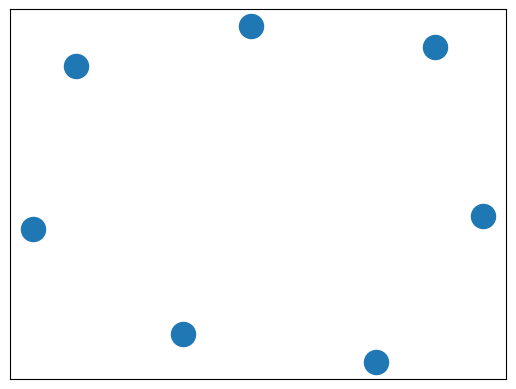

In [56]:
G_seed = nx.Graph()
for id in seed_papers:
    G_seed.add_node(id)
seed_pos=nx.spring_layout(G_seed, k=1000)
for id in seed_pos:
    seed_pos[id] *= 1000
nx.draw_networkx_nodes(G_seed, seed_pos)

Now do the rest of the papers.

In [57]:
parents = {}
G_refs = nx.Graph()
for id in seed_papers:
    if 'references' in papers[id]:
        refs = papers[id]['references']
        for ref in refs:
            G_refs.add_edge(id, ref)
            if ref not in parents:
                parents[ref] = []
            parents[ref].append(id)
ref_pos = nx.spring_layout(G_refs, k=200,
                           pos = seed_pos,
                           fixed = seed_papers)

Coloring and size

In [83]:
node_color = []
node_size = []
labels = {}
for node in G_refs.nodes():
    # Color
    if node in seed_papers:
        node_color.append((0, 0, 0, 1))
    elif node in funding and funding[node] is not None:
        node_color.append((1, 1, 0, 1))
    elif node in countries and 'edu' in countries[node]:
        node_color.append((0, 0, 1, .5))
    # elif node in countries and 'ca' in countries[node]:
    #     node_color.append((1, 0, 0, .5))
    elif node in countries and 'com' not in countries[node]:
        node_color.append((0, 1, 1, .5))
    else:
        node_color.append((.5, .5, .5, .5))
    #Size
    if node in seed_papers:
        node_size.append(150)
    else:
        node_size.append(50)
    # Label
    if node in seed_papers:
        labels[node] = seed_papers.index(node)+1


Draw

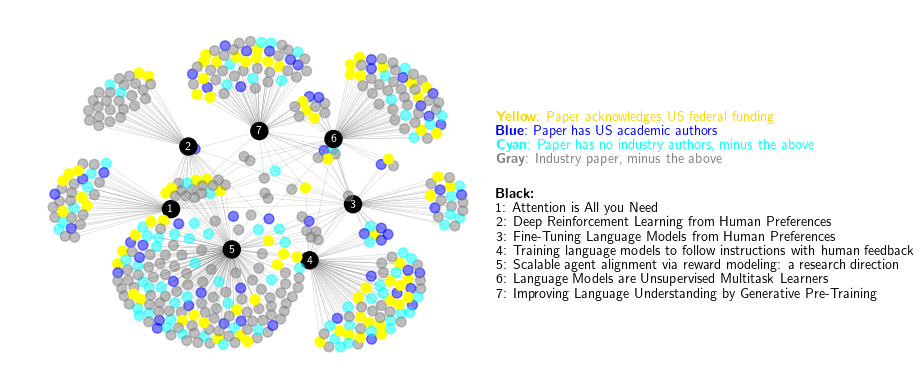

In [85]:
nx.draw_networkx_nodes(G_refs, ref_pos, 
                       node_color = node_color,
                       node_size = node_size)
nx.draw_networkx_edges(G_refs, ref_pos, 
                       width=0.25, edge_color=(0, 0, 0, .25))
nx.draw_networkx_labels(G_refs, ref_pos,
                        labels = labels,
                        font_size = 8,
                        font_color = (1, 1, 1, 1))
ax = plt.gca()
# ax.margins(0.20)
plt.axis("off")
titles = []
for n, id in enumerate(seed_papers):
    titles.append(str(n+1) + ": " + papers[id]['title'])
plt.text(2500, -1700, r'\textbf{Black:}' + '\n' + ''.join([t + '\n' for t in titles]))
plt.text(2500, 1000, r'\textbf{Yellow}: Paper acknowledges US federal funding', color="gold")
plt.text(2500, 800, r'\textbf{Blue}: Paper has US academic authors', color="blue")
# plt.text(2500, 600, r'\textbf{Red}: Paper has Canadian academic authors', color="red")
plt.text(2500, 600, r'\textbf{Cyan}: Paper has no industry authors, minus the above', color="cyan")
plt.text(2500, 400, r'\textbf{Gray}: Industry paper, minus the above', color="gray")
plt.savefig("cyan.jpg", dpi=600, bbox_inches='tight')
plt.show()

colors:
- Yellow: acknowledged US federal funding
- Blue: US university authors
- Red: Canadian university authors
- Cyan: non-corporate authors
- Grey: corporate authored

Percentage of papers with acknowledged funding

In [241]:
len(list(filter(lambda k: funding[k] is not None, funding.keys())))/len(papers)

0.17920353982300885

Percentage of papers from US Universities

In [243]:
len(list(filter(lambda k: 'edu' in countries[k], countries.keys())))/len(papers)

0.2411504424778761

Percentage of papers from corporate labs

In [245]:
len(list(filter(lambda k: len(countries[k]) == 1 and 'com' in countries[k], countries.keys())))/len(papers)


0.19247787610619468

Percentage of papers from Canadian universities

In [246]:
len(list(filter(lambda k: 'ca' in countries[k], countries.keys())))/len(papers)

0.01327433628318584

Percentage of papers with no corporate authors

In [247]:
len(list(filter(lambda k: 'com' not in countries[k], countries.keys())))/len(papers)

0.41814159292035397